In [26]:
import numpy as np
import math
import matplotlib.pyplot as plt
import graphviz
%matplotlib inline

In [27]:
def f(x):
    return 3*x**2 - 4*x + 5

In [28]:
f(3.0)

20.0

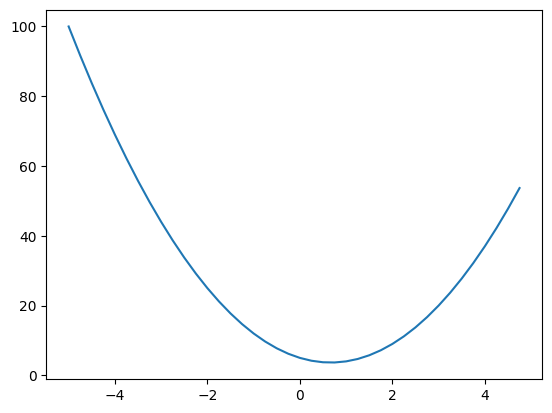

In [29]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [30]:
h = 0.00000000000001
x = 3
(f(x+h) - f(x)) / h


14.210854715202004

In [58]:
h = 0.0001

#inputs
a = 2
b = -3
c = 10

d1 = a*b + c
a += h
d2 = a*b + c
print('d1:', d1, 'd2:', d2)
print('slope:', (d2 - d1) / h)


d1: 4 d2: 3.999699999999999
slope: -3.000000000010772


In [178]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # derivative of output (L) with respect to this node
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad * 1
            other.grad += out.grad * 1
        out._backward = _backward   
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*'  )
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward    
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        # topological order all of the nodes in the graph
        self.grad = 1.0

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for node in reversed(topo):
            node._backward()

In [179]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges 

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot 


In [180]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0 + h, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    print('L1:', L1, 'L2:', L2)
    print('slope:', (L2 - L1) / h)

lol()


L1: -8.0 L2: -7.9996
slope: 3.9999999999995595


In [181]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' 

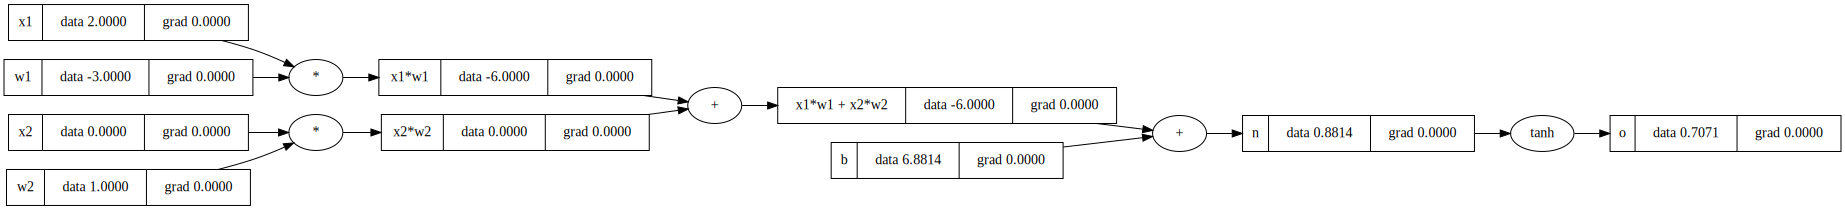

In [182]:
draw_dot(o)

In [183]:
o.backward()

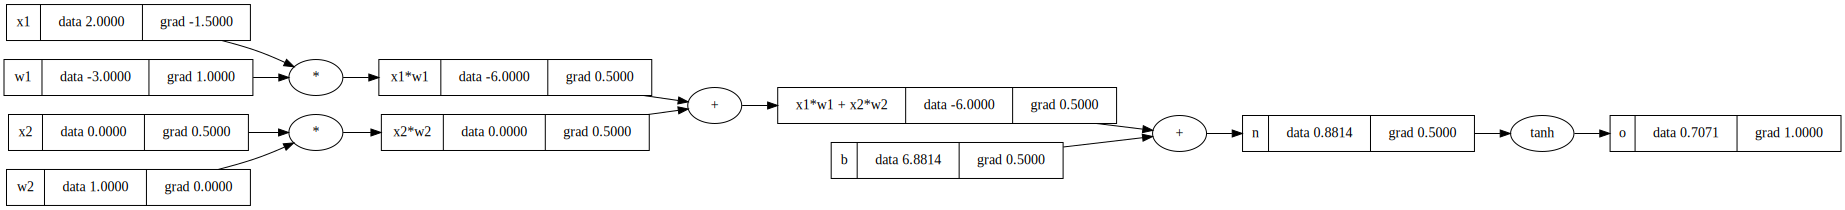

In [184]:
draw_dot(o)


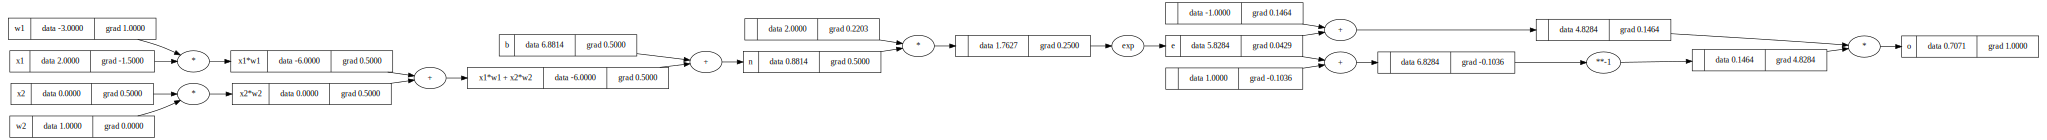

In [185]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o' 
#
o.backward()
draw_dot(o)

## Comparison with PyTorch

In [186]:
import torch
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print('w1.grad:', w1.grad.item())
print('x1.grad:', x1.grad.item())
print('w2.grad:', w2.grad.item())
print('x2.grad:', x2.grad.item())


0.7071066904050358
w1.grad: 1.0000002567688737
x1.grad: -1.5000003851533106
w2.grad: 0.0
x2.grad: 0.5000001283844369


In [280]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()] 

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [283]:
x = [2.0, 3.0, -1.0]
nn = MLP(3, [4, 4, 1])

In [284]:
nn(x)


Value(data=-0.7502607471650117)

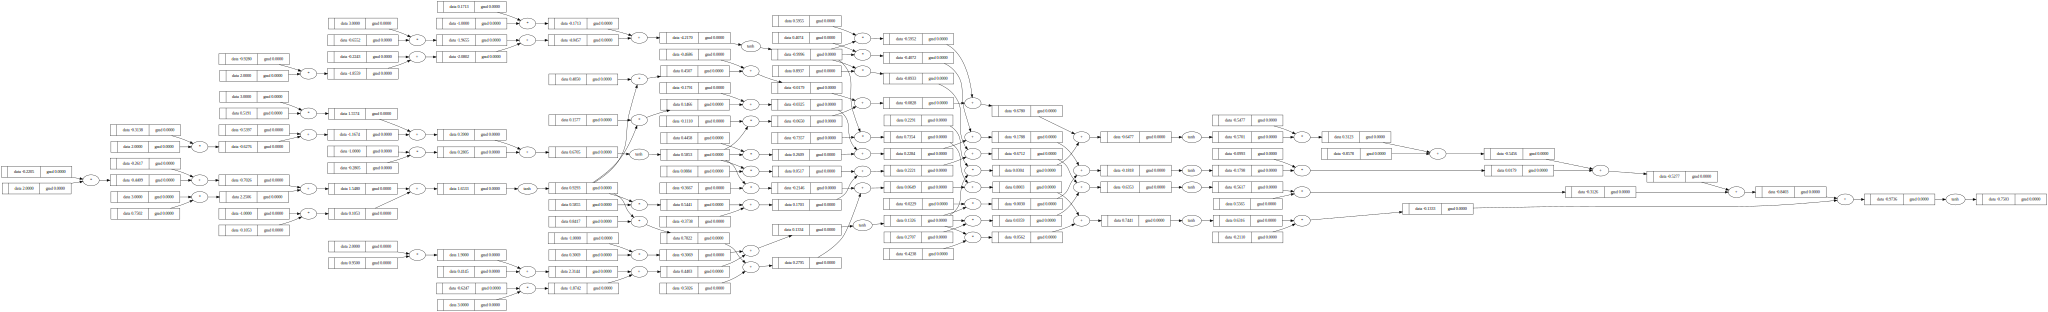

In [285]:
draw_dot(nn(x))


In [286]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [290]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # zero gradients
    for p in n.parameters():
        p.grad = 0.0

    # backward pass
    loss.backward()


    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)
loss

0 0.036185756310728366
1 0.03511690744042381
2 0.03410467217917961
3 0.03314478183857474
4 0.03223338041183406
5 0.03136697631329269
6 0.030542400695760964
7 0.02975677132759825
8 0.029007461186900223
9 0.028292071072546155
10 0.027608405647784665
11 0.026954452426871497
12 0.026328363293188405
13 0.025728438201544218
14 0.025153110770586695
15 0.024600935515503495
16 0.024070576508104957
17 0.02356079728228932
18 0.02307045182885289
19 0.02259847654548835


Value(data=0.02259847654548835)

In [291]:
ypred

[Value(data=0.9020963057312795),
 Value(data=-0.954760385401091),
 Value(data=-0.9012881575797322),
 Value(data=0.9650329779511657)]

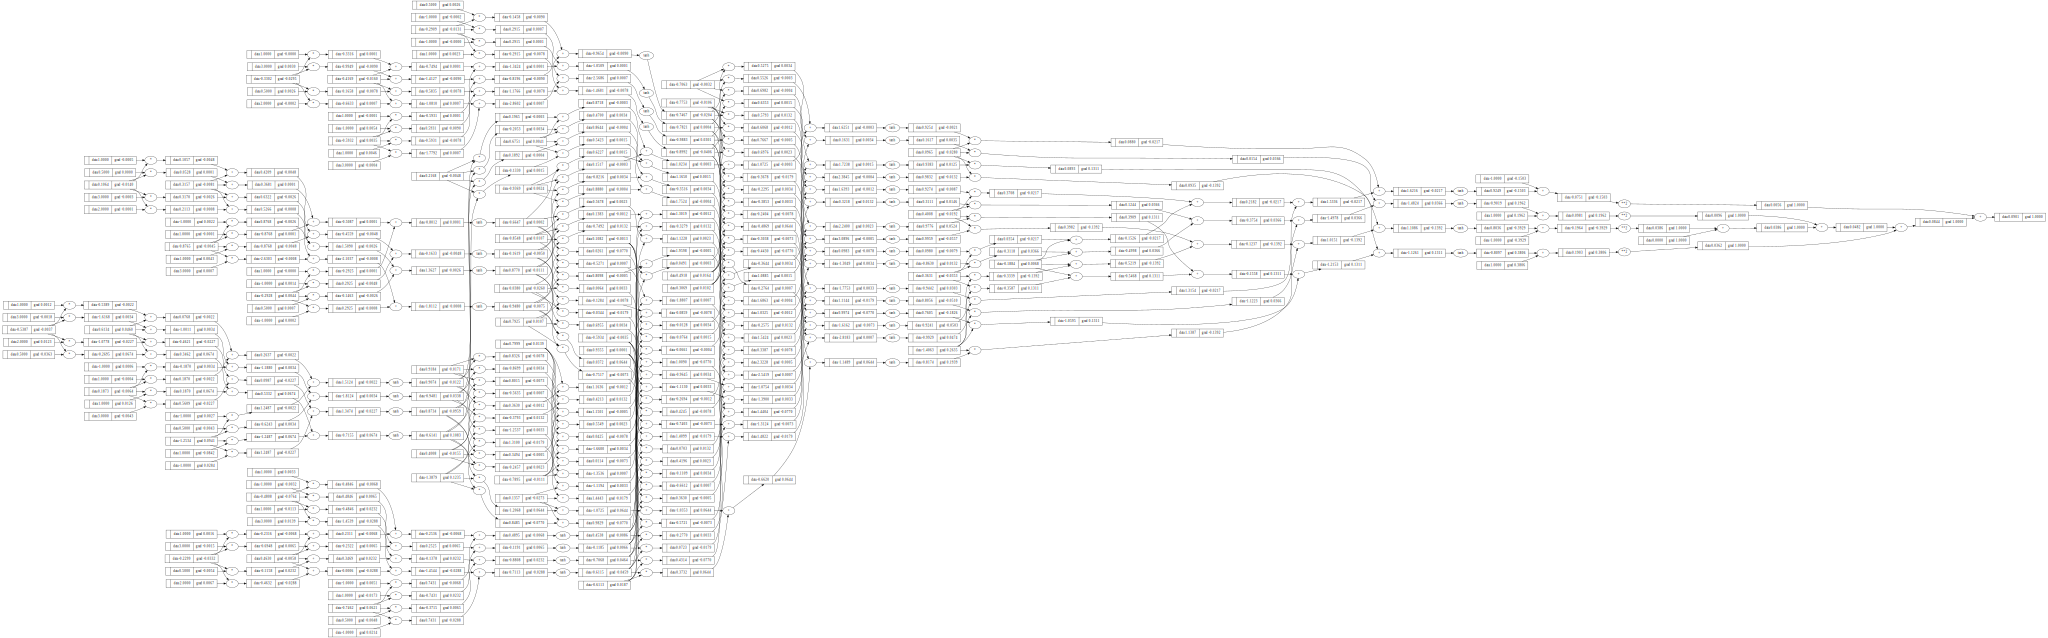

In [288]:
draw_dot(loss)